In [49]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout
from tensorflow import keras
from numba import cuda

from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import ResNet101V2
from tensorflow.keras.models import load_model

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

import gc

print("Loading Libraries Done")

Loading Libraries Done


In [50]:
main_folder = "dataset/"
RANDOM_SEED = 6

categories = os.listdir(main_folder)
try:
    categories.remove(".DS_Store")
except:
    pass
print(categories, len(categories))


['broken', 'discolored', 'pure', 'silkcut'] 4


In [51]:
TOTAL_CATEGORIES = len(categories)
IMAGE_SIZE = (224,224,3)

def image_preprocessing(main_folder,categories):

    img_list = []
    labels = []
    for index, category in enumerate(categories):
      for image in os.listdir(main_folder+"/"+category)[:500]:
        imgname = main_folder+"/"+category+"/"+image
        imgname = imgname.replace("//", "/")
        try:
          img = cv2.imread(imgname)
          # print(imgname)
          img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]))
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          img_array = Image.fromarray(img, 'RGB')
          img_list.append(np.array(img_array))
          labels.append(index)
        except NameError:
           print("error reading the file")

    images = np.array(img_list)
    labels = np.array(labels)
    images = images.astype(np.float32)
    labels = labels.astype(np.int8)
    images /= 255

    return images,labels

images, labels = image_preprocessing(main_folder,categories)
print()
print("Total Images Loaded:", len(images))


Total Images Loaded: 2000


In [52]:
# Split the dataset into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print("Training data shape:",X_train.shape)
print("Test data shape:",X_test.shape)

Training data shape: (1600, 224, 224, 3)
Test data shape: (400, 224, 224, 3)


In [53]:
del images, labels

# VGG19 model

In [54]:
EPOCHS = 200
BATCH_SIZE = 8

In [55]:
vgg = VGG19(input_shape=IMAGE_SIZE , weights='imagenet', include_top=False)

In [56]:
#do not train the pre-trained layers of VGG-19
for layer in vgg.layers:
    layer.trainable = False

In [57]:
x = Flatten()(vgg.output)
#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(TOTAL_CATEGORIES, activation='softmax')(x)
vgg_model = Model(inputs=vgg.input, outputs=prediction)
vgg_model.summary()# view the structure of the model

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [58]:
vgg_model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [59]:
#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_loss',mode='min', verbose=1, patience=5, restore_best_weights=True)

In [60]:
# fit the model
vgg_history = vgg_model.fit(X_train, y_train, validation_data=(X_test, y_test), steps_per_epoch = 10, epochs=EPOCHS, callbacks=[early_stop], batch_size=BATCH_SIZE, validation_steps = y_test.shape[0]//BATCH_SIZE, shuffle=True)

Epoch 1/200
10/10 [==============================] - 3s 325ms/step - loss: 2.5902 - accuracy: 0.1625 - val_loss: 1.9256 - val_accuracy: 0.2425
Epoch 2/200
10/10 [==============================] - 3s 277ms/step - loss: 1.7433 - accuracy: 0.3875 - val_loss: 1.9458 - val_accuracy: 0.2425
Epoch 3/200
10/10 [==============================] - 3s 288ms/step - loss: 1.7994 - accuracy: 0.2500 - val_loss: 1.4038 - val_accuracy: 0.3950
Epoch 4/200
10/10 [==============================] - 3s 282ms/step - loss: 1.6010 - accuracy: 0.3875 - val_loss: 1.5730 - val_accuracy: 0.3325
Epoch 5/200
10/10 [==============================] - 3s 278ms/step - loss: 1.6511 - accuracy: 0.3375 - val_loss: 1.7384 - val_accuracy: 0.3475
Epoch 6/200
10/10 [==============================] - 3s 283ms/step - loss: 1.8279 - accuracy: 0.3000 - val_loss: 1.2808 - val_accuracy: 0.4125
Epoch 7/200
10/10 [==============================] - 3s 281ms/step - loss: 1.4349 - accuracy: 0.4000 - val_loss: 1.1186 - val_accuracy: 0.5375

# Evaluation with Train data

In [61]:
tf.keras.backend.clear_session()
vgg_loss, vgg_acc = vgg_model.evaluate(X_train,y_train,batch_size=8)
print("Model Evaluation with Validation data:\n")
print("VGG 19 Loss:", vgg_loss)
print("VGG 19 Accuracy:", vgg_acc, "%")
#predict
y_pred = vgg_model.predict(X_train)
y_pred=np.argmax(y_pred,axis=1)
print(classification_report(y_pred,y_train))#get classification report
print()
print(confusion_matrix(y_pred,y_train))#get confusion matrix

200/200 [==============================] - 9s 42ms/step - loss: 1.1332 - accuracy: 0.4919
Model Evaluation with Validation data:

VGG 19 Loss: 1.1332409381866455
VGG 19 Accuracy: 0.4918749928474426 %
50/50 [==============================] - 6s 114ms/step
              precision    recall  f1-score   support

           0       0.38      0.55      0.45       275
           1       0.61      0.44      0.51       559
           2       0.14      0.86      0.23        65
           3       0.86      0.48      0.61       701

    accuracy                           0.49      1600
   macro avg       0.50      0.58      0.45      1600
weighted avg       0.66      0.49      0.53      1600


[[152  52  59  12]
 [120 246 151  42]
 [  7   2  56   0]
 [117 105 146 333]]


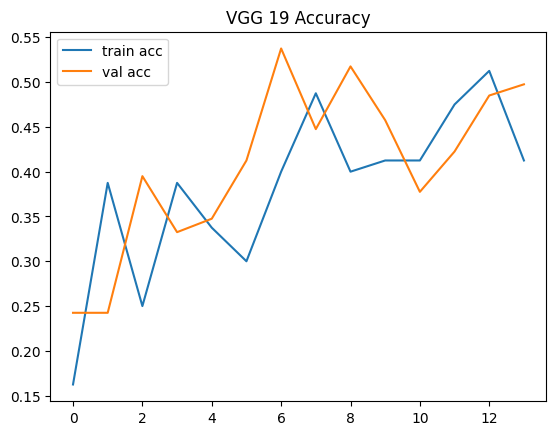

In [62]:
# Validation accuracies
plt.plot(vgg_history.history['accuracy'], label='train acc')
plt.plot(vgg_history.history['val_accuracy'], label='val acc')
plt.title("VGG 19 Accuracy")
plt.legend()
plt.show()

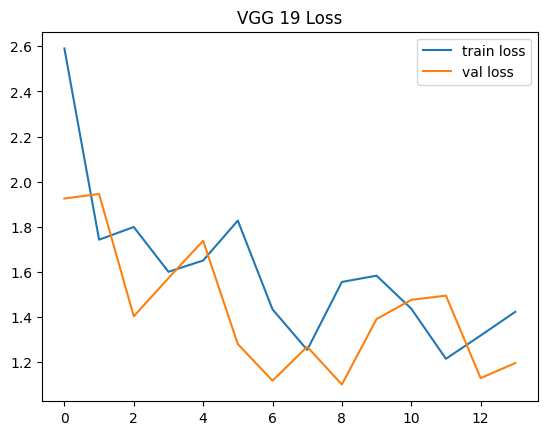

In [63]:
# Validation loss
plt.plot(vgg_history.history['loss'], label='train loss')
plt.plot(vgg_history.history['val_loss'], label='val loss')
plt.title("VGG 19 Loss")
plt.legend()
plt.show()

# Evaluation with Test data

In [64]:
test_vgg_loss, test_vgg_acc = vgg_model.evaluate(X_test,y_test,batch_size=8)
print("Model Evaluation with Testing data:\n")
print("VGG 19 Loss:", test_vgg_loss)
print("VGG 19 Accuracy:", test_vgg_acc, "%")
# predict
y_pred = vgg_model.predict(X_test)
y_pred=np.argmax(y_pred,axis=1)
print(classification_report(y_pred,y_test))#get classification report
print()
print(confusion_matrix(y_pred,y_test))#get confusion matrix


50/50 [==============================] - 2s 42ms/step - loss: 1.1019 - accuracy: 0.5175
Model Evaluation with Testing data:

VGG 19 Loss: 1.1019442081451416
VGG 19 Accuracy: 0.5174999833106995 %
13/13 [==============================] - 2s 113ms/step
              precision    recall  f1-score   support

           0       0.39      0.55      0.46        74
           1       0.58      0.43      0.49       128
           2       0.11      0.71      0.20        14
           3       0.89      0.55      0.68       184

    accuracy                           0.52       400
   macro avg       0.50      0.56      0.46       400
weighted avg       0.67      0.52      0.56       400


[[ 41  15  14   4]
 [ 40  55  27   6]
 [  1   1  10   2]
 [ 22  24  37 101]]


In [65]:
vgg_model.save("files/seed_vgg_model.h5", save_format="h5")

In [66]:
del vgg_history
del y_pred

gc.collect()

10541

# RESNET50 model

In [67]:
resnet_50 = ResNet50(input_shape=IMAGE_SIZE , weights='imagenet', include_top=False)

In [68]:
#do not train the pre-trained layers of VGG-19
for layer in resnet_50.layers:
    layer.trainable = False

In [69]:
x = Flatten()(resnet_50.output)

#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(TOTAL_CATEGORIES, activation='softmax')(x)
resnet_50_model = Model(inputs=resnet_50.input, outputs=prediction)
resnet_50_model.summary()# view the structure of the model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

 conv2_block1_0_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block1_0_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_3_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block1_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_add (Add)         (None, 56, 56, 256)  0           ['conv2_block1_0_bn[0][0]',      
                                                                  'conv2_block1_3_bn[0][0]']      
                                                                                                  
 conv2_block1_out (Activation)  (None, 56, 56, 256)  0           ['conv2_block1_add[0][0]']       
          

In [70]:
resnet_50_model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_accuracy',mode='max', verbose=1, patience=15, restore_best_weights=True)

# fit the model
resnet_50_history = resnet_50_model.fit(X_train, y_train, validation_data=(X_test, y_test), steps_per_epoch = 10, epochs=EPOCHS, callbacks=[early_stop], batch_size=BATCH_SIZE, validation_steps = y_test.shape[0]//BATCH_SIZE, shuffle=True)

Epoch 1/200
10/10 [==============================] - 5s 286ms/step - loss: 9.0909 - accuracy: 0.3000 - val_loss: 11.2454 - val_accuracy: 0.2825
Epoch 2/200
10/10 [==============================] - 1s 154ms/step - loss: 8.0090 - accuracy: 0.2000 - val_loss: 6.3463 - val_accuracy: 0.2375
Epoch 3/200
10/10 [==============================] - 1s 153ms/step - loss: 5.2016 - accuracy: 0.1625 - val_loss: 5.9101 - val_accuracy: 0.2200
Epoch 4/200
10/10 [==============================] - 1s 154ms/step - loss: 4.1127 - accuracy: 0.3250 - val_loss: 3.3068 - val_accuracy: 0.2825
Epoch 5/200
10/10 [==============================] - 1s 153ms/step - loss: 2.2017 - accuracy: 0.2625 - val_loss: 1.8524 - val_accuracy: 0.2825
Epoch 6/200
10/10 [==============================] - 1s 151ms/step - loss: 1.7473 - accuracy: 0.3250 - val_loss: 2.3758 - val_accuracy: 0.2375
Epoch 7/200
10/10 [==============================] - 1s 152ms/step - loss: 1.9417 - accuracy: 0.2250 - val_loss: 1.5949 - val_accuracy: 0.237

# Evaluation with Train data

In [71]:
resnet_50_loss,resnet_50_acc = resnet_50_model.evaluate(X_train,y_train,batch_size=8)
print("Model Evaluation with train data:\n")
print("Resnet_50 Loss:", resnet_50_loss)
print("Resnet_50 Accuracy:", resnet_50_acc*100, "%")
y_pred=resnet_50_model.predict(X_train)
y_pred=np.argmax(y_pred,axis=1)
#get classification report
print(classification_report(y_pred,y_train))
print()
print(confusion_matrix(y_pred,y_train))#get confusion matrix

200/200 [==============================] - 5s 23ms/step - loss: 2.0335 - accuracy: 0.3512
Model Evaluation with train data:

Resnet_50 Loss: 2.0334906578063965
Resnet_50 Accuracy: 35.12499928474426 %
50/50 [==============================] - 4s 62ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.72      0.33      0.45       889
           2       0.00      0.00      0.00         0
           3       0.69      0.38      0.49       711

    accuracy                           0.35      1600
   macro avg       0.35      0.18      0.23      1600
weighted avg       0.70      0.35      0.47      1600


[[  0   0   0   0]
 [246 290 233 120]
 [  0   0   0   0]
 [150 115 179 267]]


c:\Users\91997\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\91997\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\91997\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

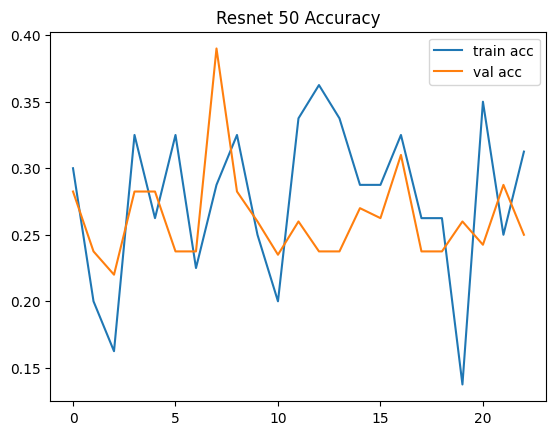

In [72]:
# accuracies
plt.plot(resnet_50_history.history['accuracy'], label='train acc')
plt.plot(resnet_50_history.history['val_accuracy'], label='val acc')
plt.title("Resnet 50 Accuracy")
plt.legend()
plt.show()

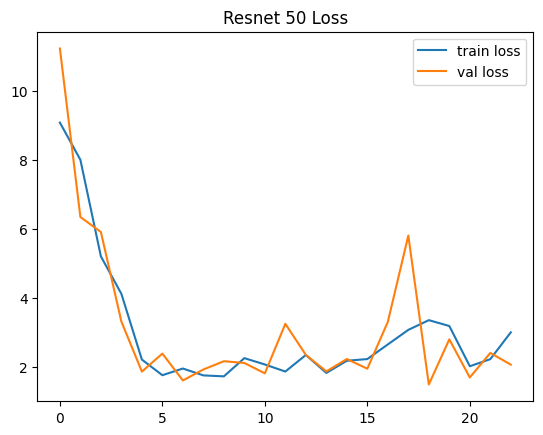

In [73]:
# loss
plt.plot(resnet_50_history.history['loss'], label='train loss')
plt.plot(resnet_50_history.history['val_loss'], label='val loss')
plt.title("Resnet 50 Loss")
plt.legend()
plt.show()

# Evaluation with Testing data

In [74]:
test_resnet_50_loss,test_resnet_50_acc = resnet_50_model.evaluate(X_test,y_test,batch_size=8)
print("Model Evaluation with Testing data:\n")
print("ResNet Loss:", test_resnet_50_loss)
print("ResNet Accuracy:", test_resnet_50_acc, "%")
# predict
y_pred = resnet_50_model.predict(X_test)
y_pred=np.argmax(y_pred,axis=1)
print(classification_report(y_pred,y_test))#get classification report
print()
print(confusion_matrix(y_pred,y_test))#get confusion matrix

50/50 [==============================] - 1s 24ms/step - loss: 1.9126 - accuracy: 0.3900
Model Evaluation with Testing data:

ResNet Loss: 1.9125944375991821
ResNet Accuracy: 0.38999998569488525 %
13/13 [==============================] - 1s 61ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.73      0.33      0.45       211
           2       0.00      0.00      0.00         0
           3       0.77      0.46      0.58       189

    accuracy                           0.39       400
   macro avg       0.37      0.20      0.26       400
weighted avg       0.75      0.39      0.51       400


[[ 0  0  0  0]
 [65 69 51 26]
 [ 0  0  0  0]
 [39 26 37 87]]


c:\Users\91997\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\91997\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\91997\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [75]:
resnet_50_model.save("files/chest_xray_resnet_50_model.h5", save_format="h5")

del resnet_50_history
del y_pred

gc.collect()

24424

# RESNET50 V2

In [76]:
resnet_50_v2 = ResNet50V2(input_shape=IMAGE_SIZE , weights='imagenet', include_top=False)

In [77]:
#do not train the pre-trained layers of VGG-19
for layer in resnet_50_v2.layers:
    layer.trainable = False

In [78]:
x = Flatten()(resnet_50_v2.output)

# three hidden layers
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)


#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(TOTAL_CATEGORIES, activation='softmax')(x)
resnet_50_v2_model = Model(inputs=resnet_50_v2.input, outputs=prediction)
# view the structure of the model
resnet_50_v2_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [79]:
resnet_50_v2_model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['acc'])

#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_accuracy',mode='max', verbose=1, patience=15, restore_best_weights=True)

# fit the model
resnet_50_v2_history = resnet_50_v2_model.fit(X_train, y_train, validation_data=(X_test, y_test), steps_per_epoch = 10, epochs=EPOCHS, callbacks=[early_stop], batch_size=BATCH_SIZE, validation_steps = y_test.shape[0]//BATCH_SIZE, shuffle=True)

Epoch 1/200
10/10 [==============================] - 5s 237ms/step - loss: 2.0194 - acc: 0.2125 - val_loss: 4.5926 - val_acc: 0.2475
Epoch 2/200
10/10 [==============================] - 1s 136ms/step - loss: 1.9055 - acc: 0.3000 - val_loss: 3.8551 - val_acc: 0.2550
Epoch 3/200
10/10 [==============================] - 1s 135ms/step - loss: 1.6864 - acc: 0.3250 - val_loss: 2.9699 - val_acc: 0.2725
Epoch 4/200
10/10 [==============================] - 1s 134ms/step - loss: 1.5419 - acc: 0.4250 - val_loss: 2.4729 - val_acc: 0.2875
Epoch 5/200
10/10 [==============================] - 1s 133ms/step - loss: 1.6499 - acc: 0.3500 - val_loss: 2.1688 - val_acc: 0.3050
Epoch 6/200
10/10 [==============================] - 1s 133ms/step - loss: 1.6701 - acc: 0.3875 - val_loss: 1.9833 - val_acc: 0.3625
Epoch 7/200
10/10 [==============================] - 1s 132ms/step - loss: 1.6825 - acc: 0.3875 - val_loss: 1.9297 - val_acc: 0.4200
Epoch 8/200
10/10 [==============================] - 1s 133ms/step - 

# Evaluation with training data

In [80]:
resnet_50_v2_loss,resnet_50_v2_acc = resnet_50_v2_model.evaluate(X_train,y_train,batch_size=8)
print("Model Evaluation with train data:\n")
print("Resnet_50_V2 Loss:", resnet_50_v2_loss)
print("Resnet_50_V2 Accuracy:", resnet_50_v2_acc*100, "%")
#predict
y_pred=resnet_50_v2_model.predict(X_train)
y_pred=np.argmax(y_pred,axis=1)
#get classification report
print(classification_report(y_pred,y_train))
print()
print(confusion_matrix(y_pred,y_train))#get confusion matrix

200/200 [==============================] - 4s 20ms/step - loss: 0.0915 - acc: 0.9762
Model Evaluation with train data:

Resnet_50_V2 Loss: 0.09152613580226898
Resnet_50_V2 Accuracy: 97.62499928474426 %
50/50 [==============================] - 4s 56ms/step
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       411
           1       0.94      1.00      0.97       382
           2       1.00      0.98      0.99       419
           3       0.99      0.98      0.99       388

    accuracy                           0.98      1600
   macro avg       0.98      0.98      0.98      1600
weighted avg       0.98      0.98      0.98      1600


[[389  20   1   1]
 [  0 381   0   1]
 [  4   2 410   3]
 [  3   2   1 382]]


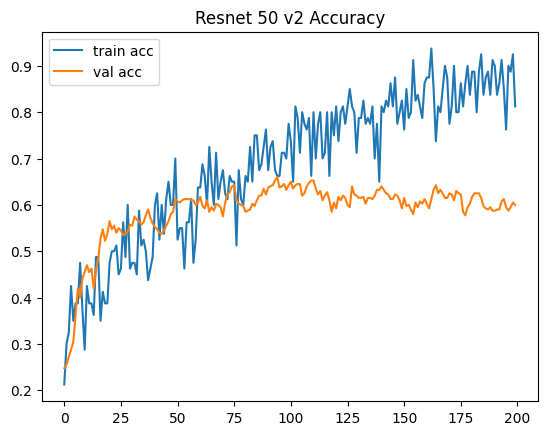

In [81]:
# accuracies
plt.plot(resnet_50_v2_history.history['acc'], label='train acc')
plt.plot(resnet_50_v2_history.history['val_acc'], label='val acc')
plt.title("Resnet 50 v2 Accuracy")
plt.legend()
plt.show()

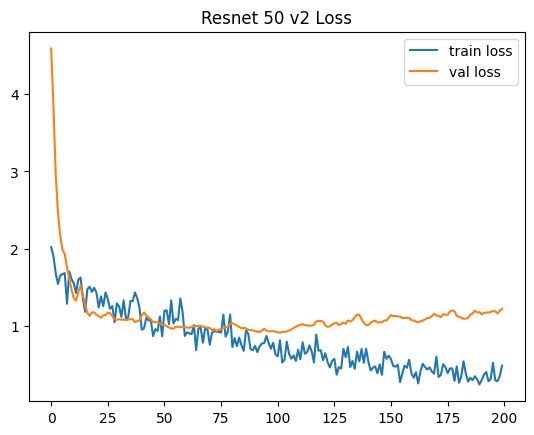

In [82]:
# loss
plt.plot(resnet_50_v2_history.history['loss'], label='train loss')
plt.plot(resnet_50_v2_history.history['val_loss'], label='val loss')
plt.title("Resnet 50 v2 Loss")
plt.legend()
plt.show()

# Evaluation with Testing data

In [83]:
test_resnet_50_v2_loss,test_resnet_50_v2_acc = resnet_50_v2_model.evaluate(X_test,y_test,batch_size=8)
print("Model Evaluation with Testing data:\n")
print("Resnet50V2 Loss:", test_resnet_50_v2_loss)
print("Resnet50V2 Accuracy:", test_resnet_50_v2_acc, "%")
# predict
y_pred = resnet_50_v2_model.predict(X_test)
y_pred=np.argmax(y_pred,axis=1)
print(classification_report(y_pred,y_test))#get classification report
print()
print(confusion_matrix(y_pred,y_test))#get confusion matrix

50/50 [==============================] - 1s 20ms/step - loss: 1.2192 - acc: 0.6000
Model Evaluation with Testing data:

Resnet50V2 Loss: 1.2191901206970215
Resnet50V2 Accuracy: 0.6000000238418579 %
13/13 [==============================] - 1s 55ms/step
              precision    recall  f1-score   support

           0       0.63      0.54      0.58       122
           1       0.47      0.64      0.55        70
           2       0.60      0.56      0.58        94
           3       0.67      0.67      0.67       114

    accuracy                           0.60       400
   macro avg       0.60      0.60      0.60       400
weighted avg       0.61      0.60      0.60       400


[[66 25 14 17]
 [12 45  6  7]
 [14 14 53 13]
 [12 11 15 76]]


In [84]:
resnet_50_v2_model.save("files/chest_xray_resnet_50_v2_model.h5", save_format="h5")

del resnet_50_v2_history
del y_pred

gc.collect()

25983

# RESNET101V2

In [85]:
resnet_101_v2 = ResNet101V2(input_shape=IMAGE_SIZE , weights='imagenet', include_top=False)

In [86]:
#do not train the pre-trained layers of VGG-19
for layer in resnet_101_v2.layers:
    layer.trainable = False

In [87]:
x = Flatten()(resnet_101_v2.output)

# three hidden layers
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)


#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(TOTAL_CATEGORIES, activation='softmax')(x)
resnet_101_v2_model = Model(inputs=resnet_101_v2.input, outputs=prediction)
# view the structure of the model
resnet_101_v2_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [88]:
resnet_101_v2_model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['acc'])

#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_accuracy',mode='max', verbose=1, patience=15, restore_best_weights=True)

# fit the model
resnet_101_v2_history = resnet_101_v2_model.fit(X_train, y_train, validation_data=(X_test, y_test), steps_per_epoch = 10, epochs=EPOCHS, callbacks=[early_stop], batch_size=BATCH_SIZE, validation_steps = y_test.shape[0]//BATCH_SIZE, shuffle=True)

Epoch 1/200
10/10 [==============================] - 8s 384ms/step - loss: 1.7915 - acc: 0.3625 - val_loss: 5.2242 - val_acc: 0.2725
Epoch 2/200
10/10 [==============================] - 2s 221ms/step - loss: 2.0344 - acc: 0.1875 - val_loss: 3.9162 - val_acc: 0.2750
Epoch 3/200
10/10 [==============================] - 2s 224ms/step - loss: 1.4654 - acc: 0.3875 - val_loss: 3.1310 - val_acc: 0.2700
Epoch 4/200
10/10 [==============================] - 2s 222ms/step - loss: 1.4567 - acc: 0.4125 - val_loss: 2.4749 - val_acc: 0.2975
Epoch 5/200
10/10 [==============================] - 2s 222ms/step - loss: 1.5603 - acc: 0.3125 - val_loss: 2.1821 - val_acc: 0.3075
Epoch 6/200
10/10 [==============================] - 2s 222ms/step - loss: 1.5201 - acc: 0.4000 - val_loss: 1.9255 - val_acc: 0.3225
Epoch 7/200
10/10 [==============================] - 2s 225ms/step - loss: 1.3627 - acc: 0.4500 - val_loss: 1.7263 - val_acc: 0.3625
Epoch 8/200
10/10 [==============================] - 2s 224ms/step - 

# Evaluation with Train data

In [89]:
resnet_101_v2_loss,resnet_101_v2_acc = resnet_101_v2_model.evaluate(X_train,y_train,batch_size=8)
print("Model Evaluation with train data:\n")
print("resnet_101_v2 Loss:", resnet_101_v2_loss)
print("resnet_101_v2 Accuracy:", resnet_101_v2_acc*100, "%")
#predict
y_pred=resnet_101_v2_model.predict(X_train)
y_pred=np.argmax(y_pred,axis=1)
#get classification report
print(classification_report(y_pred,y_train))
print()
print(confusion_matrix(y_pred,y_train))

200/200 [==============================] - 7s 34ms/step - loss: 0.1321 - acc: 0.9756
Model Evaluation with train data:

resnet_101_v2 Loss: 0.13208380341529846
resnet_101_v2 Accuracy: 97.56249785423279 %
50/50 [==============================] - 7s 99ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       388
           1       0.99      0.95      0.97       422
           2       0.94      0.99      0.97       389
           3       1.00      0.97      0.98       401

    accuracy                           0.98      1600
   macro avg       0.98      0.98      0.98      1600
weighted avg       0.98      0.98      0.98      1600


[[385   0   3   0]
 [  3 402  17   0]
 [  1   1 387   0]
 [  7   2   5 387]]


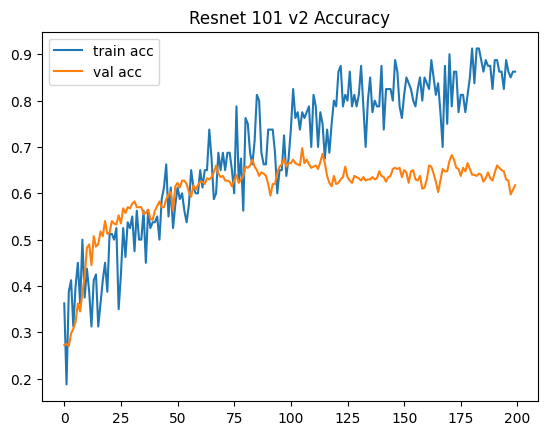

In [90]:
# accuracies
plt.plot(resnet_101_v2_history.history['acc'], label='train acc')
plt.plot(resnet_101_v2_history.history['val_acc'], label='val acc')
plt.title("Resnet 101 v2 Accuracy")
plt.legend()
plt.show()

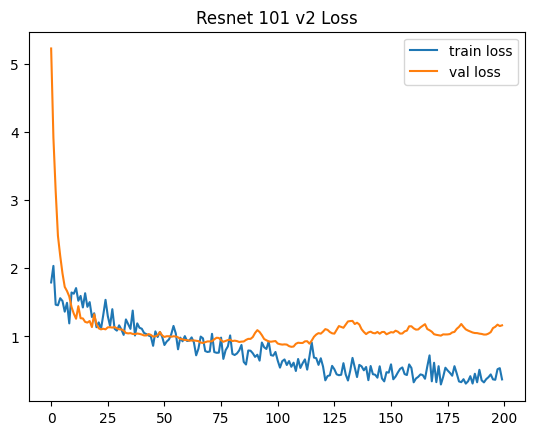

In [91]:
# loss
plt.plot(resnet_101_v2_history.history['loss'], label='train loss')
plt.plot(resnet_101_v2_history.history['val_loss'], label='val loss')
plt.title("Resnet 101 v2 Loss")
plt.legend()
plt.show()

# Evaluation with Testing data

In [92]:
test_resnet_101_v2_loss,test_resnet_101_v2_acc = resnet_101_v2_model.evaluate(X_test,y_test,batch_size=8)
print("Model Evaluation with Testing data:\n")
print("VGG 19 Loss:", test_resnet_101_v2_loss)
print("VGG 19 Accuracy:", test_resnet_101_v2_acc, "%")
# predict
y_pred = resnet_101_v2_model.predict(X_test)
y_pred=np.argmax(y_pred,axis=1)
print(classification_report(y_pred,y_test))#get classification report
print()
print(confusion_matrix(y_pred,y_test))#get confusion matrix

50/50 [==============================] - 2s 34ms/step - loss: 1.1627 - acc: 0.6175
Model Evaluation with Testing data:

VGG 19 Loss: 1.162652850151062
VGG 19 Accuracy: 0.6175000071525574 %
13/13 [==============================] - 3s 96ms/step
              precision    recall  f1-score   support

           0       0.54      0.64      0.59        87
           1       0.64      0.54      0.59       112
           2       0.38      0.69      0.49        48
           3       0.85      0.63      0.72       153

    accuracy                           0.61       400
   macro avg       0.60      0.63      0.60       400
weighted avg       0.67      0.61      0.63       400


[[56 17 11  3]
 [25 61 17  9]
 [ 9  1 33  5]
 [14 16 27 96]]


In [93]:
resnet_101_v2_model.save("files/chest_xray_resnet_101_v2_model.h5", save_format="h5")


In [94]:
del resnet_101_v2_history
del y_pred

gc.collect()

46418

# Model comparision with Training Data

[49.18749928474426, 35.12499928474426, 97.62499928474426, 97.56249785423279]


Text(0.5, 1.0, 'Accuracy score Comparison (Higher is better)')

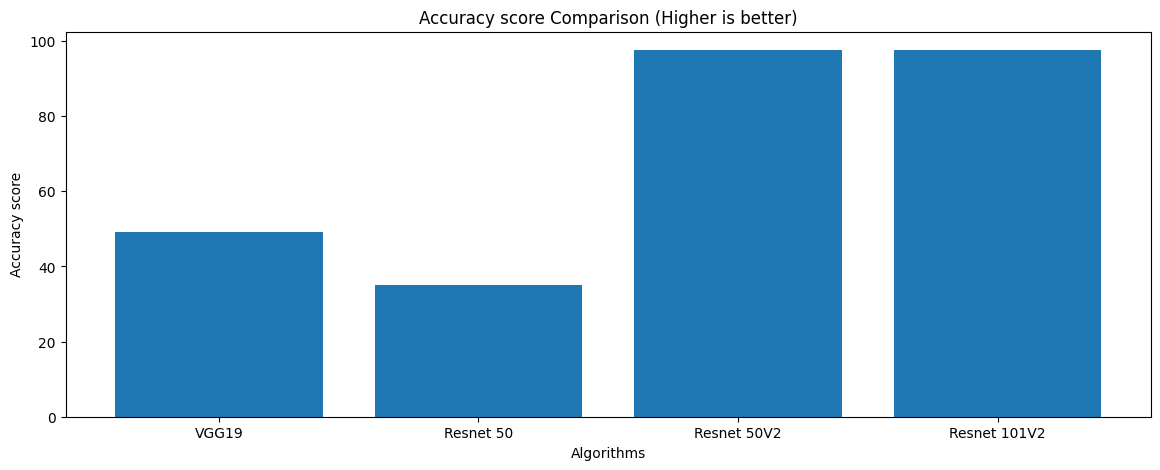

In [95]:
algorithms = ["VGG19","Resnet 50","Resnet 50V2","Resnet 101V2"]
Accuracy = [vgg_acc*100,resnet_50_acc*100,resnet_50_v2_acc*100,resnet_101_v2_acc*100]
print(Accuracy)

plt.figure(figsize=[14,5])
plt.bar(algorithms, Accuracy)
plt.xlabel("Algorithms")
plt.ylabel("Accuracy score")
plt.title("Accuracy score Comparison (Higher is better)")

# Model comparision with Testing Data

[51.749998331069946, 38.999998569488525, 60.00000238418579, 61.75000071525574]


Text(0.5, 1.0, 'Accuracy score Comparison (Higher is better)')

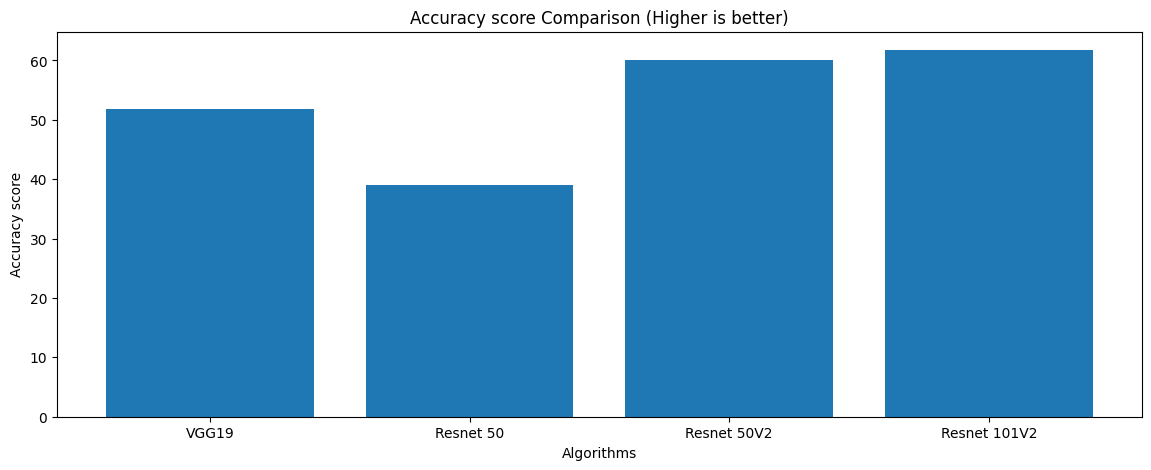

In [96]:
algorithms = ["VGG19","Resnet 50","Resnet 50V2","Resnet 101V2"]
Accuracy = [test_vgg_acc*100,test_resnet_50_acc*100,test_resnet_50_v2_acc*100,test_resnet_101_v2_acc*100]
print(Accuracy)

plt.figure(figsize=[14,5])
plt.bar(algorithms, Accuracy)
plt.xlabel("Algorithms")
plt.ylabel("Accuracy score")
plt.title("Accuracy score Comparison (Higher is better)")